In [1]:
# # # # # ########### RUN FIRST TIME ONLY ################
# import pandas as pd
# stats = pd.DataFrame()
# index = 0

In [2]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [4]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    return seed
    

In [5]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"

In [6]:
tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [7]:
tr['Sex'].unique() 

array(['Male', 'Female'], dtype=object)

In [8]:
# # Import label encoder 
# from sklearn import preprocessing 
  
# # label_encoder object knows how to understand word labels. 
# label_encoder = preprocessing.LabelEncoder() 

In [9]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [10]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [11]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [12]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [13]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [14]:
COLS = ['Sex','SmokingStatus'] #
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#=================

In [15]:
data.head(2)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0,1,0,1,0,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0,1,0,1,0,0


In [16]:
# data['Sex']= label_encoder.fit_transform(data['Sex']) 
  
# data['Sex'].unique() 

In [17]:
data.head(2)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0,1,0,1,0,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0,1,0,1,0,0


In [18]:
x = data[['Age','min_FVC','base_week', 'Percent']].values

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

In [20]:
import seaborn as sns

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = RobustScaler()
#scaler = StandardScaler()
# scaler  = Normalizer()
z = scaler.fit_transform(x)

colnames = ['age', 'BASE','week', 'percent']
z = pd.DataFrame(z, columns=colnames)

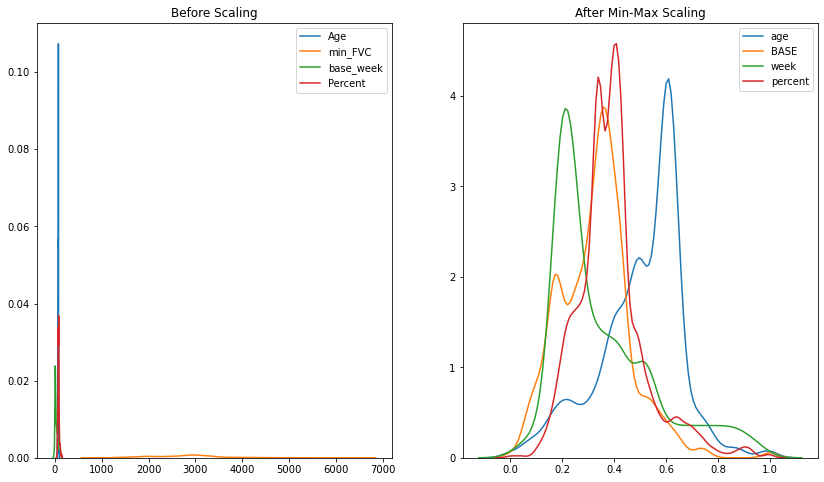

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

ax1.set_title('Before Scaling')
sns.kdeplot(data['Age'], ax=ax1)
sns.kdeplot(data['min_FVC'], ax=ax1)
sns.kdeplot(data['base_week'], ax=ax1)
sns.kdeplot(data['Percent'], ax=ax1)

ax2.set_title('After Min-Max Scaling')
sns.kdeplot(z['age'], ax=ax2)
sns.kdeplot(z['BASE'], ax=ax2)
sns.kdeplot(z['week'], ax=ax2)
sns.kdeplot(z['percent'], ax=ax2)

In [23]:
data[['age', 'BASE', 'week', 'percent']] = z[['age', 'BASE', 'week', 'percent']]

In [24]:

# data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
# data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
# data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
# data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [25]:
SEED = seed_everything(42)
NFOLD        = 5
EPOCHS       = 2000
BATCH_SIZE   = 128

M_LOSS       = 0.775
LR           = 0.1
DECAY        = 0.01     

kf = KFold(n_splits=NFOLD)

In [26]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [27]:
#tr.shape, chunk.shape, sub.shape

In [28]:
# FE+=['Sex']
# print(FE)

### BASELINE NN 

In [29]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model():
    z = L.Input((9,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(M_LOSS), optimizer=tf.keras.optimizers.Adam(lr=LR), metrics=[score])
    return model

In [30]:
net = make_model()
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          1000        Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [31]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))
delta = np.zeros((z.shape[0], 3))

In [32]:
# print(history.history.keys())

In [33]:
%%time

net = make_model()
history=net.fit(z, y, batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z, y)) #

Epoch 1/2000
12/12 [==============================] - 0s 28ms/step - loss: 543.7910 - score: 12.0198 - val_loss: 348.6602 - val_score: 8.4365
Epoch 2/2000
12/12 [==============================] - 0s 6ms/step - loss: 231.6096 - score: 8.4032 - val_loss: 181.1669 - val_score: 8.0673
Epoch 3/2000
12/12 [==============================] - 0s 6ms/step - loss: 129.8198 - score: 7.6358 - val_loss: 110.8612 - val_score: 7.7567
Epoch 4/2000
12/12 [==============================] - 0s 6ms/step - loss: 82.8820 - score: 7.3769 - val_loss: 66.1701 - val_score: 7.0523
Epoch 5/2000
12/12 [==============================] - 0s 6ms/step - loss: 56.0749 - score: 6.9097 - val_loss: 52.3468 - val_score: 6.7709
Epoch 6/2000
12/12 [==============================] - 0s 6ms/step - loss: 50.9753 - score: 6.8027 - val_loss: 47.7566 - val_score: 6.6909
Epoch 7/2000
12/12 [==============================] - 0s 6ms/step - loss: 47.2181 - score: 6.7198 - val_loss: 45.0971 - val_score: 6.6964
Epoch 8/2000
12/12 [======

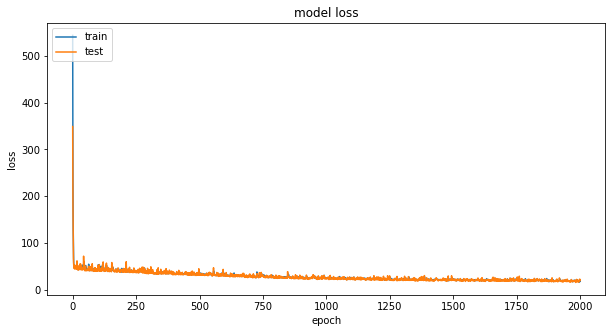

In [34]:
fig, plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#==============

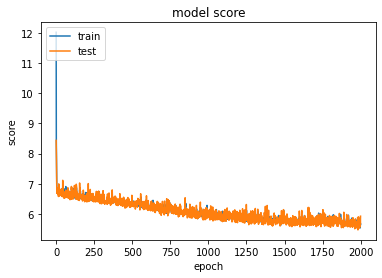

In [35]:
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('model score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
# history=net.fit(z, y, batch_size=BATCH_SIZE, epochs=100, 
#             validation_data=(z, y)) #

In [37]:
# history=net.fit(z, y, batch_size=BATCH_SIZE, epochs=700, 
#             validation_data=(z, y)) #

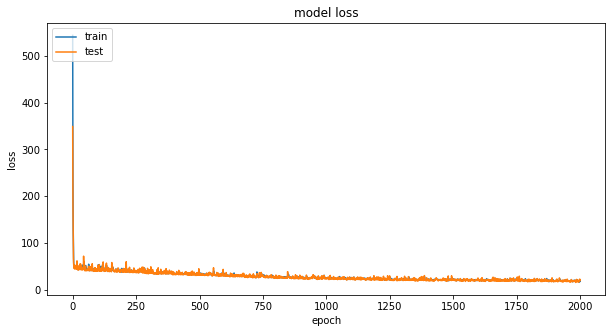

In [38]:
fig, plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

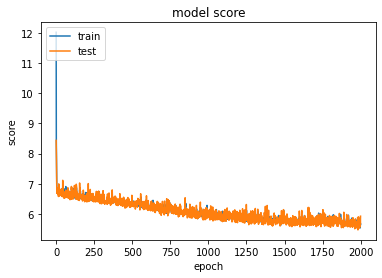

In [39]:
plt.plot(history.history['score'])
plt.plot(history.history['val_score'])
plt.title('model score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
x = 

SyntaxError: invalid syntax (<ipython-input-40-0f44b287cd63>, line 1)

In [41]:
print("train", net.evaluate(z, y, verbose=0, batch_size=BATCH_SIZE))
print("val", net.evaluate(z, y, verbose=0, batch_size=BATCH_SIZE))
print("predict val...")
pred = net.predict(z, batch_size=BATCH_SIZE, verbose=0)
print("predict test...")
pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0)
delta += net.predict(z)

train [21.566823959350586, 5.9251837730407715]
val [21.566823959350586, 5.9251837730407715]
predict val...
predict test...


In [42]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
# print(sigma_opt, sigma_mean)

In [43]:
# Scoring

o_clipped = np.maximum(delta[:,2] - delta[:,0], 70)
delta = np.minimum(np.abs(delta[:, 1] - y), 1000)
sqrt = (np.sqrt((2)))
score = (-(sqrt * (delta))/(o_clipped)) - tf.math.log(sqrt * o_clipped)

logL_Score = np.mean(score)

In [44]:
data = [[index, logL_Score, sigma_opt, unc.mean(), unc.min(),  unc.max(), (unc>=0).mean(),
         BATCH_SIZE, EPOCHS,  NFOLD, M_LOSS, LR, DECAY ,SEED]]
columns = ['S.No','Score', 'meanAbseErr', 'unc.mean', 'unc.min', 'unc.max',  '(unc>=0)',
           'Bsize', 'epoch', 'NFOLD', 'M_LOSS', 'LR', 'DECAY', 'seed']
kernal_stats = pd.DataFrame(data, columns=columns)
# print("current kernal state")
# kernal_stats

NameError: name 'index' is not defined

In [45]:
stats = pd.concat([stats, kernal_stats])
stats.to_csv('kernal.csv', index = False)
index+=1

# print('kernal stats of every version')
stats

#0 -6.490188 142.335620 234.993966 25.237061 485.192871 1.0 128 800 5 0.775 0.100 0.010 42

NameError: name 'stats' is not defined

In [46]:
# colnames_unc = ['unc']
# unc_d = pd.DataFrame(unc, columns=colnames_unc)
# unc_d.to_csv('unc.csv', index = False)

In [47]:
# plt.hist(unc_d)

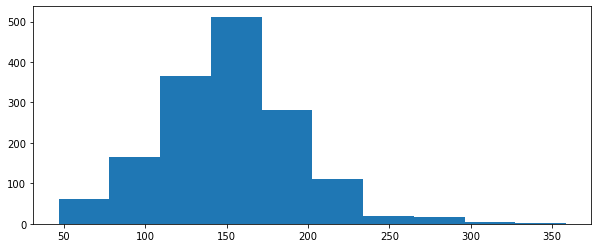

In [48]:
# unc_d = unc_d.values
# fig, plt.subplots(figsize=(10, 4))
# plt.hist(unc_d)
# plt.show()

fig, plt.subplots(figsize=(10, 4))
plt.hist(unc)
plt.show()

### PREDICTION

In [49]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [50]:
sub['FVC1'] = pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]

In [51]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [52]:
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,3041.273682,140.054932
1541,ID00419637202311204720264_-11,3020,100.0,3035.262207,139.639404
1542,ID00419637202311204720264_-10,3020,100.0,3029.250488,139.224121
1543,ID00419637202311204720264_-9,3020,100.0,3023.238770,138.808838
1544,ID00419637202311204720264_-8,3020,100.0,3017.227051,138.393311
1545,ID00419637202311204720264_-7,3020,100.0,3011.603760,137.964844
1546,ID00419637202311204720264_-6,3020,100.0,3006.012451,137.535156
1547,ID00419637202311204720264_-5,3020,100.0,3000.421387,137.105957
1548,ID00419637202311204720264_-4,3020,100.0,2984.222656,138.704346
1549,ID00419637202311204720264_-3,3020,100.0,2967.919922,140.322021


In [53]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [54]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3041.273682,140.054932,3041.273682,140.054932
1541,ID00419637202311204720264_-11,3035.262207,139.639404,3035.262207,139.639404
1542,ID00419637202311204720264_-10,3029.250488,139.224121,3029.250488,139.224121
1543,ID00419637202311204720264_-9,3023.238770,138.808838,3023.238770,138.808838
1544,ID00419637202311204720264_-8,3017.227051,138.393311,3017.227051,138.393311


In [55]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2702.713712,415.277825,1930.215088,2604.577698,2772.295898,2900.832947,3431.683105
Confidence,730.0,149.614002,18.658741,108.348389,133.895325,147.368042,162.889221,199.112061
FVC1,730.0,2702.713712,415.277825,1930.215088,2604.577698,2772.295898,2900.832947,3431.683105
Confidence1,730.0,149.614002,18.658741,108.348389,133.895325,147.368042,162.889221,199.112061


In [56]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [57]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [58]:
submm = pd.read_csv('../input/osic36175/submission_6.175.csv')
submm = submm.values
colnames = ['Patient','FVC_175', 'Confidence_175']
submm = pd.DataFrame(submm, columns=colnames)

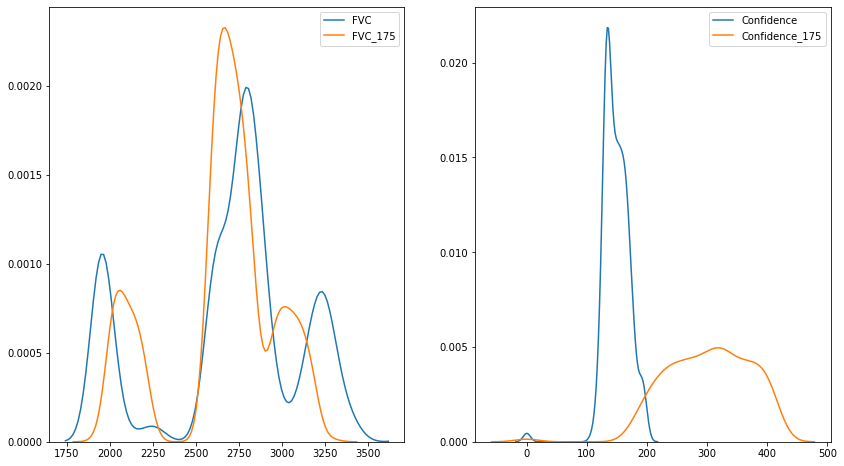

In [59]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

sns.kdeplot(subm['FVC'], ax=ax1)
sns.kdeplot(subm['Confidence'], ax=ax2)

sns.kdeplot(submm['FVC_175'], ax=ax1)
sns.kdeplot(submm['Confidence_175'], ax=ax2)

In [60]:
# !pip install jovian --upgrade --quiet
# import jovian
# jovian.commit(project='osic-new-era')